In [1]:
import os,sys,signal
import math

import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting

import musicnet

from time import time

from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='1'

import torch
from torch.nn.functional import conv1d, mse_loss
import torch.nn.functional as F
import torch.nn as nn

if torch.cuda.is_available():
    device = "cuda:0"
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
# Network Parameters
epochs = 20
train_size = 100000
test_size = 50000

lr = 1e-4
momentum = .95

pitch_shift = 0
jitter = 0.
num_workers = 10
sequence = 1

# lvl1 convolutions are shared between regions
m = 128
k = 512              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 100

regions = 1 + (window - n_fft)//stride

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers
kwargs = {'num_workers': num_workers, 'pin_memory': True, 'worker_init_fn': worker_init}

In [3]:
# function for returning scientific notation in a plot
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return fr'${a} \times 10^{{{b}}}$'

In [4]:
result_dict = {'loss_history_train': [],
               'avgp_history_train': [],
               'loss_history_test': [],
               'avgp_history_test': [],
               'parameters': {}}

result_dict['parameters']['train_size'] = train_size
result_dict['parameters']['test_size'] = test_size
result_dict['parameters']['lr'] = lr
result_dict['parameters']['pitch_shift'] = pitch_shift
result_dict['parameters']['jitter'] = jitter

# Preparing Dataset

In [5]:
start = time()
root = './data/'
train_set = musicnet.MusicNet(root=root, epoch_size=train_size,sequence=sequence
                              , train=True, download=True, refresh_cache=False, 
                              window=window, mmap=False, pitch_shift=pitch_shift, jitter=jitter)
test_set = musicnet.MusicNet(root=root, train=False, download=True,sequence=sequence
                             , refresh_cache=False, window=window, epoch_size=test_size, mmap=False)
print("Data loaded, time used = {:2.2f} seconds".format(time()-start))

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

Data loaded, time used = 28.00 seconds


# Defining Models

In [6]:
Loss = torch.nn.MSELoss()
def L(yhatvar,y):
    return Loss(yhatvar,y) * 128/2

In [31]:
class Model(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(Model, self).__init__()
        # Create filter windows for stft
        wsin, wcos = musicnet.create_filters(n_fft,k, windowing="hann", freq_scale='log')
        wsin = torch.tensor(wsin, dtype=torch.float)
        wcos = torch.tensor(wcos, dtype=torch.float)
            
        # Creating Layers
        self.conv_sin = torch.nn.Conv1d(1,k,n_fft,stride)
        self.conv_cos = torch.nn.Conv1d(1,k,n_fft,stride)
        self.linear1 = torch.nn.Linear(regions*k, k, bias=False)
        self.linear2 = torch.nn.Linear(k, m, bias=False)
        
        # Give Fourier transform as a Prior
        self.conv_sin.weight = torch.nn.Parameter(wsin)
        self.conv_cos.weight = torch.nn.Parameter(wcos)
        
        torch.nn.init.normal_(self.linear1.weight, std=1e-4) # initialize
        torch.nn.init.normal_(self.linear2.weight, std=1e-4) # initialize
        
        self.avg = avg
        
    def forward(self,x):
        zx = self.conv_sin(x[:,None,:]).pow(2) \
           + self.conv_cos(x[:,None,:]).pow(2) # Doing STFT by using conv1d
        z2 = self.linear1(torch.log(zx + 10e-8).view(x.data.size()[0],regions*k))
        y = self.linear2(torch.relu(z2))
        return y

In [32]:
model = Model()
model.to(device)

Model(
  (conv_sin): Conv1d(1, 512, kernel_size=(4096,), stride=(512,))
  (conv_cos): Conv1d(1, 512, kernel_size=(4096,), stride=(512,))
  (linear1): Linear(in_features=12800, out_features=512, bias=False)
  (linear2): Linear(in_features=512, out_features=128, bias=False)
)

In [33]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# optimizer = SWA(base_opt, swa_start=0, swa_freq=1, swa_lr=0.000001)

try:
    with train_set, test_set:
        print("epoch\ttrain loss\ttest loss\ttrain avg\ttest avg\ttime\tutime")
        for e in range(epochs):
            yground = torch.Tensor(batch_size*len(train_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(train_loader), m)
            avgp, loss_e = 0.,0
            t = time()
            for i, (x,y) in enumerate(train_loader):
                print(f"training {i}/{len(train_loader)} batches", end = '\r')
                optimizer.zero_grad()
                
                # making x and y into pytorch dealable format
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                yhatvar = model(x)
                loss = L(yhatvar,y)
                loss.backward()
                loss_e += loss.item() #getting the number
                
                yground[i*batch_size:(i+1)*batch_size] = y.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
                
                optimizer.step()
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())  
            
            result_dict['loss_history_train'].append(loss_e/len(train_loader))
            result_dict['avgp_history_train'].append(avgp)   
            t1 = time()
            avgp, loss_e = 0.,0.           
#             optimizer.swap_swa_sgd() # change to average weight
            
            # For testing
            yground = torch.Tensor(batch_size*len(test_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(test_loader), m)
            
            for i, (x_test,y_test) in enumerate(test_loader):
                print(f"testing {i}/{len(test_loader)} batches", end = '\r')
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                yhatvar = model(x_test)
                loss_e += L(yhatvar, y_test).item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y_test.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())
            result_dict['loss_history_test'].append(loss_e/len(test_loader))
            result_dict['avgp_history_test'].append(avgp)
            print('{}\t{:2f}\t{:2f}\t{:2f}\t{:2f}\t{:2.1f}\t{:2.1f}'.\
                  format(e,
                         result_dict['loss_history_train'][-1],result_dict['loss_history_test'][-1],
                         result_dict['avgp_history_train'][-1],result_dict['avgp_history_test'][-1],
                         time()-t, time()-t1))


        
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print("Finsihed")
    

epoch	train loss	test loss	train avg	test avg	time	utime
0	1.139109	0.764806	0.377728	0.551680	26.3	6.0
1	0.901887	0.672097	0.590404	0.612026	26.5	6.0
2	0.815488	0.621910	0.639946	0.641580	26.4	6.0
3	0.776663	0.602469	0.661822	0.659472	36.5	5.9
4	0.759287	0.585606	0.671499	0.668410	26.7	5.9
5	0.746036	0.591295	0.679629	0.668576	28.2	6.5
6	0.734756	0.573558	0.685099	0.680039	28.6	6.4
7	0.731850	0.575601	0.690110	0.675977	28.4	6.1
8	0.724222	0.572465	0.695046	0.683573	28.6	6.5
9	0.726096	0.569816	0.693146	0.685088	29.0	7.0
10	0.714210	0.569590	0.700053	0.686643	28.2	6.5
11	0.712321	0.562878	0.702024	0.687388	26.2	5.9
12	0.711209	0.564792	0.702166	0.684086	27.9	7.3
13	0.709218	0.561467	0.705135	0.691695	26.9	6.0
14	0.705278	0.553109	0.706378	0.695768	26.0	5.9
15	0.701767	0.559486	0.707848	0.695172	28.5	7.0
16	0.702769	0.554816	0.709682	0.692639	29.0	7.3
17	0.701024	0.556631	0.709629	0.696938	29.0	7.4
18	0.696500	0.562934	0.712569	0.694640	28.9	7.3
19	0.695669	0.549147	0.713320	0.700124	29

(0.3, 0.8)

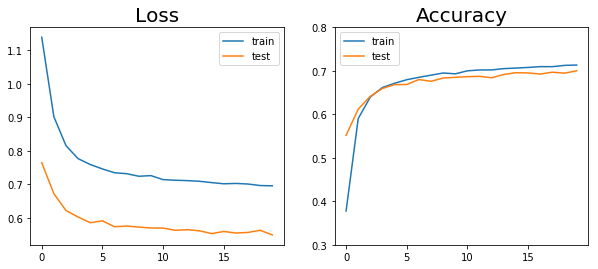

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(result_dict['loss_history_train'])
ax[0].plot(result_dict['loss_history_test'])
ax[0].legend(['train', 'test'])
ax[0].set_title('Loss', size=20)

ax[1].plot(result_dict['avgp_history_train'])
ax[1].plot(result_dict['avgp_history_test'])
ax[1].legend(['train', 'test'])
ax[1].set_title('Accuracy', size=20)
ax[1].set_ylim(0.3,0.80)

# Mir_Eval stats

In [35]:
print('AvgP\tP\tR\tAcc\tETot\tESub\tEmiss\tEfa')
Accavg = 0
Etotavg = 0
for songid in test_set.rec_ids:
    Y_pred, Y_true = musicnet.get_piano_roll(songid, test_set, model,
                                             window=window, m=m, stride=-1)
    Yhatpred = Y_pred > 0.4
    _,_,_,Acc,Etot = musicnet.get_mir_accuracy(Y_pred, Y_true, m=m)
    Accavg += Acc
    Etotavg += Etot

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
76.25	76.39	68.36	0.56	0.41	0.12	0.20	0.09
76.84	71.95	72.12	0.56	0.45	0.11	0.17	0.17
41.91	52.98	39.51	0.29	0.79	0.17	0.44	0.18
69.16	61.50	76.01	0.52	0.64	0.08	0.16	0.40
66.56	62.66	73.59	0.51	0.51	0.20	0.07	0.24
74.17	73.21	64.87	0.52	0.46	0.13	0.22	0.11
67.87	72.51	57.76	0.47	0.51	0.13	0.30	0.09
71.22	67.93	67.08	0.51	0.51	0.13	0.20	0.18
77.45	75.57	66.52	0.55	0.46	0.09	0.24	0.12
69.67	68.94	68.59	0.52	0.49	0.13	0.18	0.18


In [37]:
print('Average Accuracy: \t{:2.2f}\nAverage Error: \t\t{:2.2f}'
      .format(Accavg/len(test_set.rec_ids)*100, Etotavg/len(test_set.rec_ids)*100))

Average Accuracy: 	50.25
Average Error: 		52.30


# Saving weights and results

In [38]:
torch.save(model.state_dict(), './weights/three-layer')
with open('./result_dict/three-layer', 'wb') as f:
    pickle.dump(result_dict, f)